## Imports

In [60]:
from rov import *
import numpy as np
import struct
from scapy.all import *
import time
import polarTransform
import wand
from scipy.spatial.transform import Rotation as R
from scipy.signal import medfilt
from skimage import data
from skimage import filters
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.animation as animation

## Loading Data

In [3]:
sonar_data = SonarData("../00-Data/14.07.23/01-Raw/SONAR-14.07.23-13.36.bin")
rov_location = LocationData("../00-Data/14.07.23/01-Raw/LOC-14.07.23-13.38.pcapng", nozeroes = True)

Initialized  ../00-Data/14.07.23/01-Raw/SONAR-14.07.23-13.36.bin  with  1193  packages in  1 m  4 s
Parsed  9027 / 18807  location packets.


## Computing Binarization

In [37]:
binarized, resolution = compute_binarization(sonar_data)

Binarized  1193  packages in  11 m  13 s


## Plotting Binarized Data

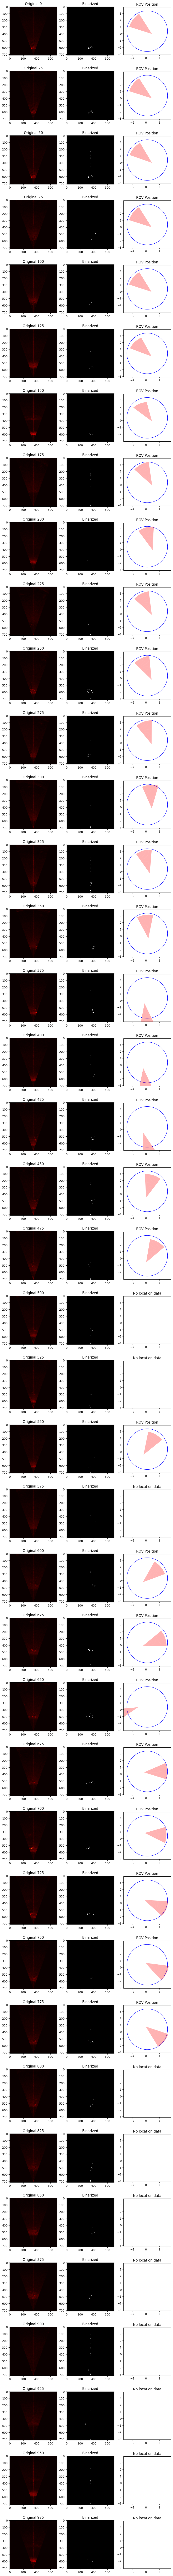

In [54]:
fig, axes = plt.subplots(ncols=3, nrows=40, figsize=(10, 160))
ax = axes.ravel()
used_percentage = 0.7
for i in range(40):
    id = i * 25
    angle = np.deg2rad(sonar_data.angles[-1] - sonar_data.angles[0])
    start_angle = 0.5* (np.pi - angle)
    end_angle = start_angle + angle
    image, _ = polarTransform.convertToCartesianImage(  np.rot90(sonar_data.sonar_array[id]),
                                                            finalRadius=1020,
                                                            initialAngle = start_angle,
                                                            finalAngle= end_angle,
                                                            order=4)
    image = image[0 : math.floor(image.shape[0] * used_percentage)][:]
    ax[i * 3].imshow(np.flipud(image),vmin=0, vmax=255, cmap='hot')
    ax[i * 3].set_title('Original ' + str(id))

    ax[i * 3 + 1].imshow(np.flipud(binarized[id]),cmap='gray')
    ax[i * 3 + 1].set_title('Binarized')

    ax[i * 3 + 2].set_title('ROV Position')
    ax[i * 3 + 2].set_ylim(-3.1,3.9)
    ax[i * 3 + 2].set_xlim(-3.3,3.7)
    ax[i * 3 + 2].set_aspect('equal', 'box')
    pck_time = sonar_data.sonar_times[id]
    min_diff = 10**10
    t_id = -1
    for q in range(len(rov_location.loc_times)):
        rot_time = rov_location.loc_times[q]
        if abs(rot_time - pck_time) < min_diff:
            t_id = q
            min_diff = abs(rot_time - pck_time)
    if min_diff > 0.5:
        ax[i * 3 + 2].set_title('No location data')
    else:
        tri_num = 20
        ax[i * 3 + 2].add_patch(plt.Circle((0.2, 0.37), 3, color='b', fill=False))
        rot_x = rov_location.rot_x[t_id]
        rot_y = rov_location.rot_y[t_id]
        rot_z = rov_location.rot_z[t_id]
        pos_x = rov_location.x[t_id]
        pos_y = rov_location.y[t_id]
        pos_z = rov_location.z[t_id]
    
        offset_v = np.array([pos_x/1000,pos_y/1000,pos_z/1000])
        r = R.from_euler('xyz', [rot_x, rot_y, rot_z], degrees=True)
        tri_num = 10
        angle = np.deg2rad(sonar_data.angles[-1] - sonar_data.angles[0])
        start_angle = -0.5 * angle
        step = angle / tri_num
        for k in range(tri_num):
            x1 = np.cos(start_angle + step * k) * sonar_data.range * used_percentage
            y1 = np.sin(start_angle + step * k) * sonar_data.range * used_percentage
            z1 = 0.0
            
            v1 = np.array([x1, y1, z1])
            v1 = r.apply(v1)
            v1 += offset_v

            x2 = np.cos(start_angle + step * (k+1)) * sonar_data.range * used_percentage
            y2 = np.sin(start_angle + step * (k+1)) * sonar_data.range * used_percentage
            z2 = 0.0
            
            v2 = np.array([x2, y2, z2])
            v2 = r.apply(v2)
            v2 += offset_v

            v3 = offset_v
            collection = plt.Polygon(np.stack((v1[0:2], v2[0:2],v3[0:2])), alpha = 0.3, facecolor = 'r',linewidth=1)
            ax[i * 3 + 2].add_patch(collection)
        
    

plt.show()

## Generating Pointcloud

In [58]:
pointcloud = make_pointcloud(sonar_data.sonar_times, binarized, rov_location, resolution)

Created pointcloud with 252947  in  2 m  17 s


In [61]:
save_pointcloud(pointcloud, "../00-Data/14.07.23/02-Processed/PCL-14.07.23-13.36-new.ply")